# Detecção de Cantos e Características

Prof. Dr. Gustavo Resque  
MSc. Tiago Araújo

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import *
import cv2

In [2]:
### Utilitário de ajuda para plotar os gráficos e imagens
def get_ax(rows=1, cols=1,figsize=(4,4), dpi=100, img_mode=True):
    fig, axes = plt.subplots(figsize=figsize, dpi = dpi, nrows=rows, ncols=cols)
    if img_mode:
        if rows == 1 and cols == 1:
            axes.clear()
            axes.get_xaxis().set_visible(False)
            axes.get_yaxis().set_visible(False)
        else:
            for ax in axes:
                if (isinstance(ax,np.ndarray)):
                    for a in ax:
                        a.clear()
                        a.get_xaxis().set_visible(False)
                        a.get_yaxis().set_visible(False)   
                else:
                    ax.clear()
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)
    return axes

# Cantos

* O encontro de duas retas em direções diferentes
* Importantes para o entendimento e localização de objetos em uma imagem
* Podem ser utilizados para compreensão da cena em três dimensões

In [3]:
def mostrarcantos(titles=None):
    size = 100
    preto = np.zeros((size,size), dtype=np.uint8)
    preto2 = preto.copy()
    preto3 = preto.copy()
    branco = np.ones((size,size//2), dtype=np.uint8)
    axes = get_ax(1,3, (8,2))
    preto2[:,size//2:] = branco
    preto3[size//2:,size//2:] = branco[:size//2]
    axes[0].imshow(preto, cmap='gray')
    axes[1].imshow(preto2, cmap='gray')
    axes[2].imshow(preto3, cmap='gray')
    if titles is not None:
        for i in range(len(titles)):
            axes[i].set_title(titles[i])

<IPython.core.display.Javascript object>


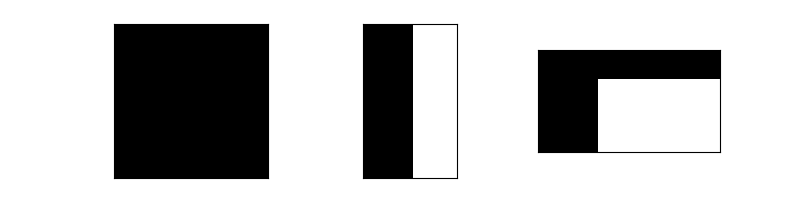

In [4]:
mostrarcantos() # problema do diafragma

# Processo

1. Determinar ângulo dos cantos
2. Para cada pixel, separar entre
 * cantos, bordas, regiões homogêneas
3. Eliminar múltiplas respostas vizinhas
4. Eliminar cantos não significantes através de um limiar 

<IPython.core.display.Javascript object>


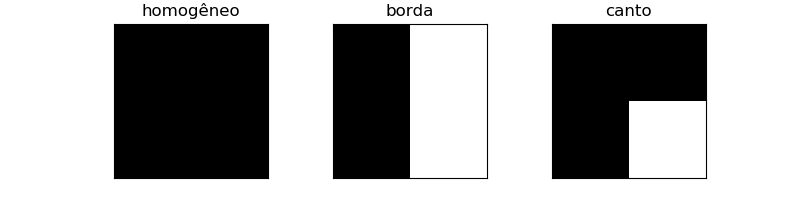

In [5]:
mostrarcantos(['homogêneo', 'borda', 'canto'])

### Harris

In [6]:
def cantoHarris(path):
    ax = get_ax(1,3,(8,2))
    img = cv2.cvtColor(cv2.imread(path,1), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dst = np.zeros(img.shape,dtype=np.float32)
    
    slider_viz = IntSlider(min=2,max=5,step=1,value=2,description='Vizinhança')
    slider_kernel = IntSlider(min=1,max=9,step=2,value=3,description='Tam Kernel')
    
    def update(args):
        imcp = img.copy()
        canvas = np.zeros(img.shape,dtype=np.uint8)

        dst = cv2.cornerHarris(gray, slider_viz.value, slider_kernel.value, 0.04) #vizinhança, tamanho kernel, fator
        dst = cv2.dilate(dst,None)
        canvas[dst>0.01*dst.max()]=[255,255,255]
        dst = cv2.dilate(dst,None)
        imcp[dst>0.01*dst.max()]=[0,255,0]
        
        ax[0].imshow(img)
        ax[1].imshow(canvas)
        ax[2].imshow(imcp)
    
    update({'new':1})
    slider_viz.observe(update, names='value')
    slider_kernel.observe(update, names='value')
    display(slider_viz, slider_kernel)

<IPython.core.display.Javascript object>


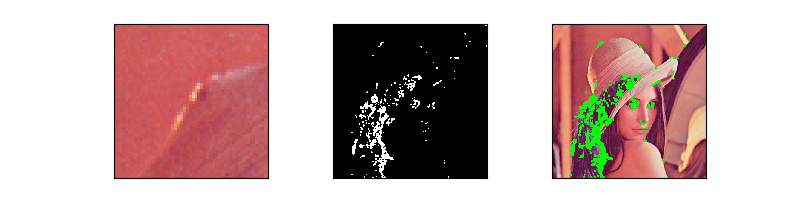

IntSlider(value=2, description='Vizinhança', max=5, min=2)

IntSlider(value=3, description='Tam Kernel', max=9, min=1, step=2)

In [7]:
cantoHarris('dataset/lenna.png')

### FAST

In [8]:
def cantosfast(path):
    ax = get_ax(1,3,(8,2))
    img = cv2.cvtColor(cv2.imread(path,1), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    fast = cv2.FastFeatureDetector_create()

    slider_thres = IntSlider(min=5,max=100,step=5,value=10,description='Limiar')

    def update(args):
        fast.setThreshold(slider_thres.value)
        canvas = np.zeros(img.shape,dtype=np.uint8)
        kp = fast.detect(img,None)
        
        img2 = cv2.drawKeypoints(canvas, kp, None, color=(255,255,255))
        img3 = cv2.drawKeypoints(gray, kp, None, color=(255,0,0))
        
        ax[0].imshow(img)
        ax[1].imshow(img2)
        ax[2].imshow(img3)
    
    update({'new':1})
    slider_thres.observe(update, names='value')
    display(slider_thres)

<IPython.core.display.Javascript object>


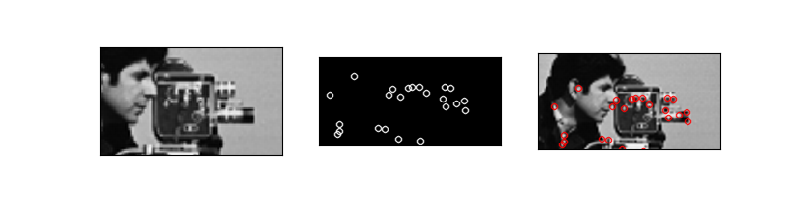

IntSlider(value=10, description='Limiar', min=5, step=5)

In [9]:
cantosfast('dataset/cameraman.tif')

# Casamento de características

In [10]:
def getMatches(im1, im2, extractor=cv2.AKAZE_create()):
    # Iniciar extrator
    featureextractor = extractor
    
    # encontrar descritores e keypoints com o extrator 
    kp1, des1 = featureextractor.detectAndCompute(im1,None)
    kp2, des2 = featureextractor.detectAndCompute(im2,None)
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    return bf.knnMatch(des1,des2, k=2), kp1, kp2

def getgoodmatches(matches, t=.75):
    good = []
    for m,n in matches:
        if m.distance < t*n.distance:
            good.append([m])
    return good
  
def lowcontrast(im, factor):
    img = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    img = img.astype(np.int)
    img[:,:,2] += factor
    img = cv2.convertScaleAbs(img)
    return cv2.cvtColor(img, cv2.COLOR_HSV2RGB)    

def casamentocaracteristicas(path_object, path_scene):
    
    axes = get_ax(1,1,(9,6))
    
    img_obj_cor = cv2.cvtColor(cv2.imread(path_object,1), cv2.COLOR_BGR2RGB) # imagem do objeto
    img_scn_cor = cv2.cvtColor(cv2.imread(path_scene,1), cv2.COLOR_BGR2RGB) # imagem de treino
    img_obj = cv2.cvtColor(img_obj_cor, cv2.COLOR_RGB2GRAY)
    img_scn = cv2.cvtColor(img_scn_cor, cv2.COLOR_RGB2GRAY)
    
    matches, kp1, kp2 = getMatches(img_obj, img_scn)
    
    slider_thres = FloatSlider(min=0.25,max=1,step=0.05,value=0.75,description='Limiar')
    
    def update(args):
        good = getgoodmatches(matches, slider_thres.value)
        img3 = cv2.drawMatchesKnn(lowcontrast(img_obj_cor,-80),kp1,
                                  lowcontrast(img_scn_cor,-80),kp2,
                                  good,None,flags=0,matchColor=(0,255,0),singlePointColor = (255,0,255))
        axes.imshow(img3)
    
    update({'new':1})
    slider_thres.observe(update, names='value')
    display(slider_thres)

<IPython.core.display.Javascript object>


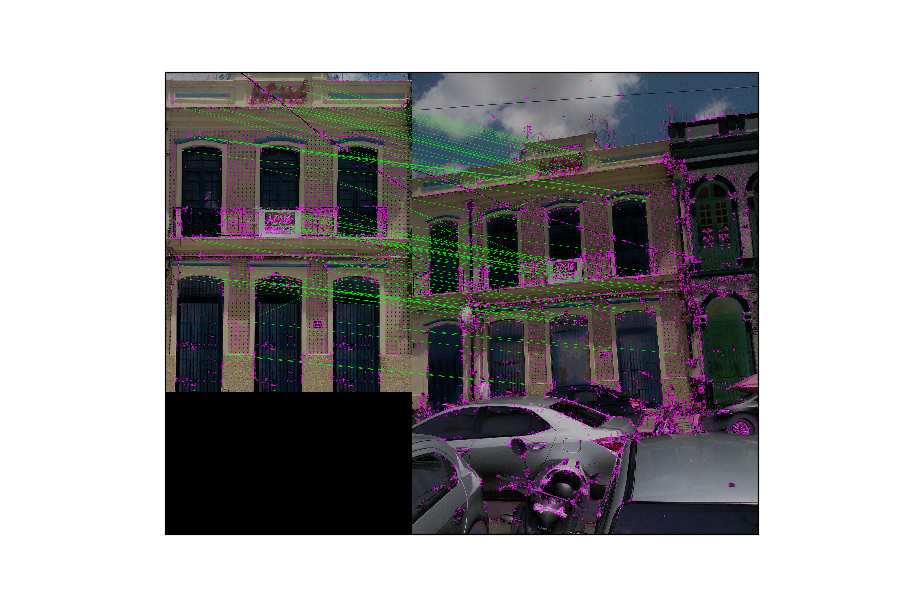

FloatSlider(value=0.75, description='Limiar', max=1.0, min=0.25, step=0.05)

In [11]:
casamentocaracteristicas('dataset/casaache_base.jpg','dataset/casaache_1.jpg')

In [12]:
def getHomography(good, kp1, kp2, imshape):
    if len(good)>10:
        src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h, w = imshape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        return cv2.perspectiveTransform(pts,M)
    return None


def desenharhomografia(path_object, path_scene):
    axes = get_ax(1,1,(9,6))
    
    img_obj_cor = cv2.cvtColor(cv2.imread(path_object, 1), cv2.COLOR_BGR2RGB) # imagem do objeto
    img_scn_cor = cv2.cvtColor(cv2.imread(path_scene, 1), cv2.COLOR_BGR2RGB) # imagem de treino
    img_obj = cv2.cvtColor(img_obj_cor, cv2.COLOR_RGB2GRAY)
    img_scn = cv2.cvtColor(img_scn_cor, cv2.COLOR_RGB2GRAY)
    
    matches, kp1, kp2 = getMatches(img_obj, img_scn)
    
    #slider_thres = FloatSlider(min=0.25,max=1,step=0.05,value=0.75,description='Limiar')
    
    def update(args):
        good = getgoodmatches(matches, .75) #slider_thres.value
        
        dst = getHomography(good, kp1, kp2, img_obj.shape[:2])
        
        if dst is not None:
            im_hg = cv2.polylines(lowcontrast(img_scn_cor,-80), [np.int32(dst)], True, (0, 255, 255), 20, cv2.LINE_AA)
        else:
            im_hg = lowcontrast(img_scn_cor, -80)
        
        img3 = cv2.drawMatches( lowcontrast(img_obj_cor, -80),kp1,
                                im_hg,kp2,
                                np.asarray(good).ravel(),None,flags=0,matchColor=(0,255,0),singlePointColor=(255,0,255))
        axes.imshow(img3)
    
    update({'new':1})
    #slider_thres.observe(update, names='value')
    #display(slider_thres)
    

<IPython.core.display.Javascript object>


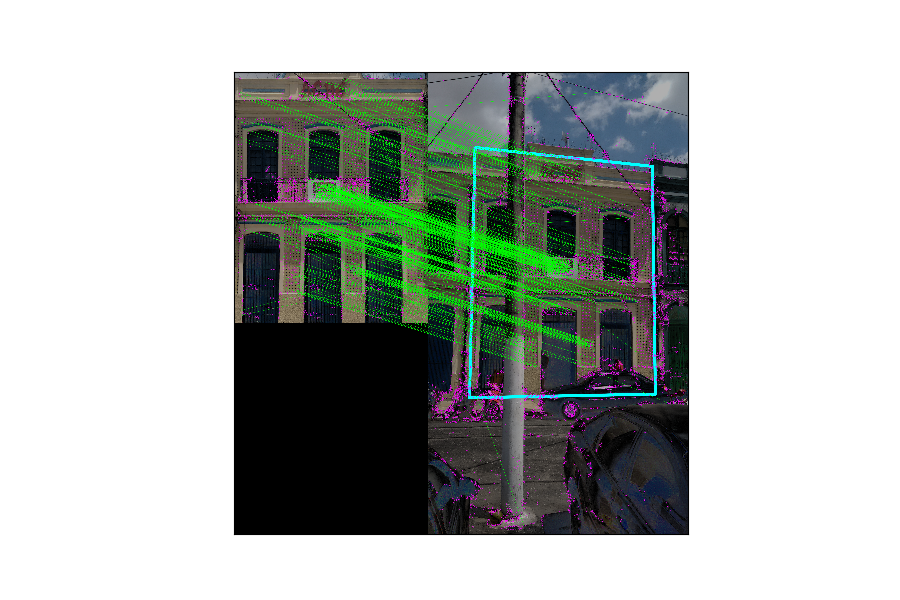

In [15]:
desenharhomografia('dataset/casaache_base.jpg','dataset/casaache_3.jpg')